In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

In [ ]:
%cd /content/drive/MyDrive/nnPJ2
!ls

In [ ]:
!pip install torchtoolbox==0.1.5
!pip install git+https://github.com/lessw2020/Ranger21.git

In [ ]:
import torch
import numpy as np
from PIL import Image
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchtoolbox.nn import LabelSmoothingLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
trainset = torchvision.datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root=".", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def evaluate(model):
  with torch.no_grad():
    acc = 0
    n = 0
    for image, label in testloader:
      image = image.to(device)
      label = label.to(device)
      logit = model(image)
      pred = logit.argmax(dim=1)
      acc += torch.eq(pred, label).float().sum().item()
      n += image.size(0)
    acc /= n
    return acc


def train(model, epoch, criterion, optimizer):
  converge_hist = []
  step = 0
  for i in range(epoch):
    model.train()
    for image, label in trainloader:
      image = image.to(device)
      label = label.to(device)
      optimizer.zero_grad()
      logit = model(image)
      loss = criterion(logit, label)
      loss.backward()
      optimizer.step()
      if step%10==0:
        converge_hist.append(loss.item())
      step += 1
  model.eval()
  acc = evaluate(model)
  return acc, converge_hist

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 3)
    self.fc1 = nn.Linear(32 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
def showAcc(models, names):
  plt.figure()
  acc = []
  for k, (model, loss_func, optimizer) in enumerate(models):
    torch.manual_seed(30)
    acc.append(train(model, 10, loss_func, optimizer)[0])
  plt.plot(list(range(len(acc))), acc, marker='o',linestyle=None)
  plt.xticks([i for i in range(len(names))],[str(i) for i in names])
  plt.show()


def showLoss(models, names):
  plt.figure()
  acc=[]
  for k, (model, loss_func, optimizer) in enumerate(models):
    torch.manual_seed(30)
    acc, loss = train(model, 10, loss_func, optimizer)
    plt.plot(list(range(len(loss[100:]))), loss[100:], alpha = 0.5, label=str(names[k])+'('+str(round(acc,4))+')')
  plt.legend()
  plt.show()


def showLandscape(models,names):
  plt.figure()
  for k, model in enumerate(models):
    losses = []
    loss_func = nn.CrossEntropyLoss()
    for lr in [1e-1, 5e-2, 3e-2, 1e-2]:
      torch.manual_seed(30)
      model._init_weights()
      optimizer = optim.SGD(model.parameters(), lr=lr)
      losses.append(train(model, 10, loss_func, optimizer)[1])
    minLoss = np.array(losses).min(axis=0)
    maxLoss = np.array(losses).max(axis=0)
    x = list(range(len(minLoss)))
    temp = plt.plot(x, minLoss, linewidth=0.5, alpha=0.9)
    plt.plot(x, maxLoss, color=temp[-1]._color, linewidth=0.5, alpha=0.9)
    plt.fill_between(x, minLoss, maxLoss, color=temp[-1]._color, alpha=0.5, label=str(names[k]))
  plt.legend()
  plt.show()

In [ ]:
def imshow(img):
  img = img.numpy().transpose((1,2,0))
  plt.imshow(img)
  plt.show()


def showKernel(model):
  for module in model.modules():
    if isinstance(module, nn.Conv2d):
      kernels = module.weight
      c_out, c_int, k_h, k_w = kernels.shape
      kernel_show = make_grid(kernels.view(-1, 3, k_h, k_w), normalize=True, scale_each=True, nrow=5)
      imshow(kernel_show.cpu())
      return


def showFeature(model):
  ori_img = trainset[0][0].to(device)
  imshow(ori_img)
  ori_img.unsqueeze_(0)
  for module in model.modules():
    if isinstance(module, nn.Conv2d):
      feature_map = module(ori_img)
      feature_map.transpose_(0, 1)
      feature_show = make_grid(feature_map, normalize=True, scale_each=True, nrow=5)
      imshow(feature_show.cpu())
      return

**Different Filters**

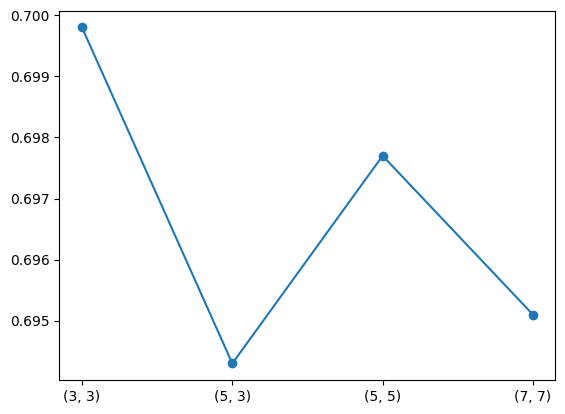

In [ ]:
class FilterNet(nn.Module):
  def __init__(self, filter_size):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, filter_size[0], padding=filter_size[0]//2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, filter_size[1], padding=filter_size[1]//2)
    self.fc1 = nn.Linear(32 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Models = []
names = [(3,3), (5,3), (5,5), (7,7)]
for fs in names:
  torch.manual_seed(30)
  net = FilterNet(fs).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models, names)

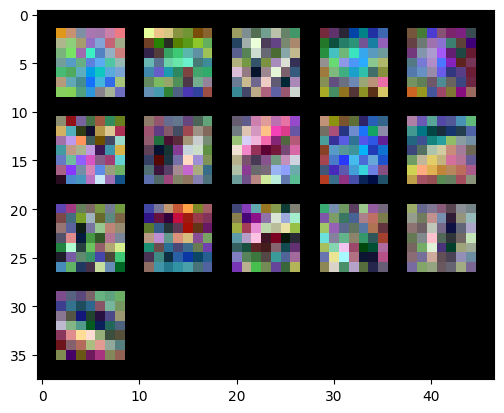

In [ ]:
showKernel(Models[-1][0])

**Different Channels**

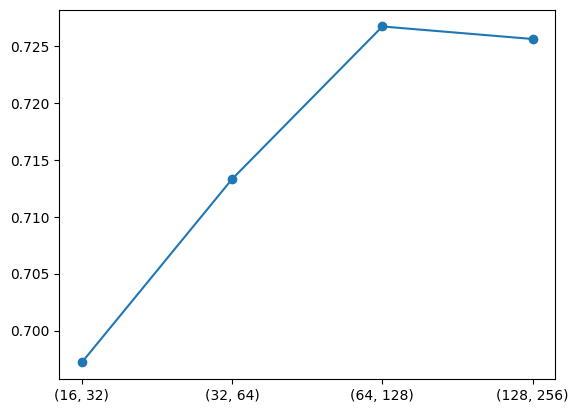

In [ ]:
class ChannelNet(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.conv1 = nn.Conv2d(3, channels[0], 5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(channels[0], channels[1], 5, padding=2)
    self.fc1 = nn.Linear(channels[1] * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Models = []
names = [(16,32), (32,64), (64,128), (128,256)]
for ch in names:
  torch.manual_seed(30)
  net = ChannelNet(ch).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models, names)

**Different Depth**

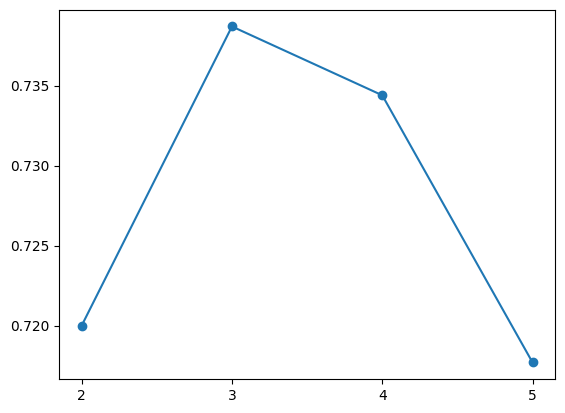

In [ ]:
class DepthNet(nn.Module):
  def __init__(self, depth):
    super().__init__()
    convLayer = [nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(True), nn.MaxPool2d(2, 2)]
    for i in range(depth):
      convLayer.append(nn.Conv2d(32*(2**i),64*(2**i),5,padding=2))
      convLayer.append(nn.ReLU(True))
      convLayer.append(nn.MaxPool2d(2, 2))
    self.feature = nn.Sequential(*convLayer)
    self.fc1 = nn.Linear(2**(13-depth), 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.feature(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Models = []
for d in [1, 2, 3, 4]:
  torch.manual_seed(30)
  net = DepthNet(d).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models,[2,3,4,5])

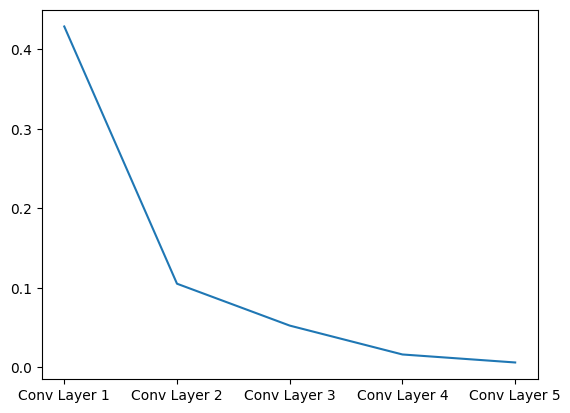

In [ ]:
a = Models[-1][0]
relative_norm = []
for module in a.modules():
  if isinstance(module, nn.Conv2d):
    relative_norm.append((torch.linalg.vector_norm(module.weight.grad)/torch.linalg.vector_norm(module.weight.data)).item())
plt.figure()
plt.plot(relative_norm)
plt.xticks([i for i in range(len(relative_norm))],["Conv Layer {}".format(i+1) for i in range(len(relative_norm))])
plt.show()

**Different Loss Functions**

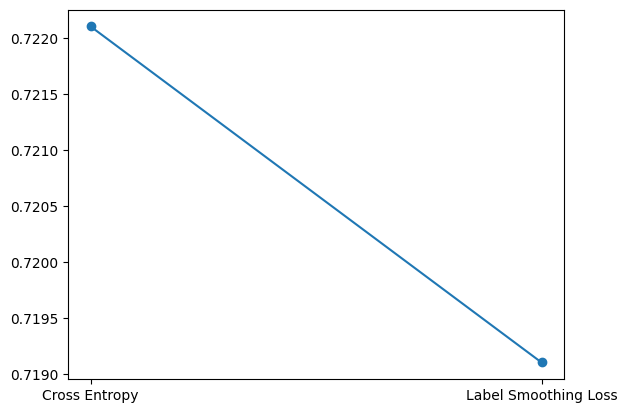

In [ ]:
class LossNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Models = []
for loss in [nn.CrossEntropyLoss(), LabelSmoothingLoss(10, 0.1)]:
  net = LossNet().to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, loss, optimizer))
showAcc(Models,["Cross Entropy", "Label Smoothing Loss"])

**Different Activations**

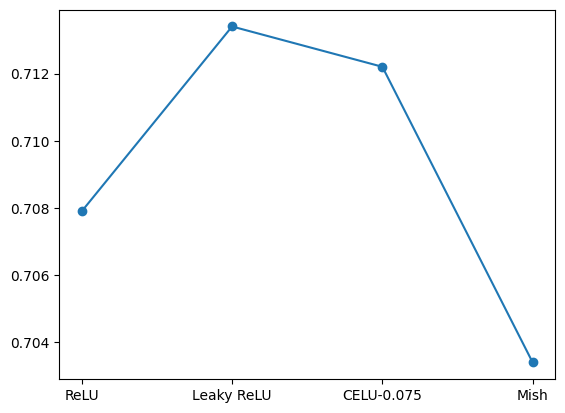

In [ ]:
class ActivationNet(nn.Module):
  def __init__(self, activation):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 10)
    self.activation = activation
  
  def forward(self, x):
    x = self.pool(self.activation(self.conv1(x)))
    x = self.pool(self.activation(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.fc3(x)
    return x

Models = []
for activation in [F.relu, F.leaky_relu, nn.CELU(0.075), nn.Mish()]:
  torch.manual_seed(30)
  net = ActivationNet(activation).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models,["ReLU","Leaky ReLU", "CELU-0.075", "Mish"])

**Batch-Normalization**

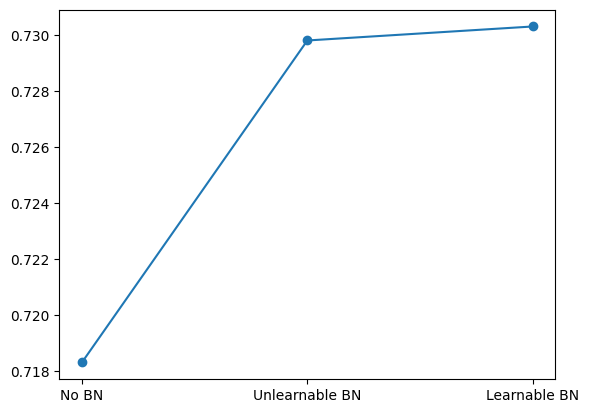

In [ ]:
class BNNet(nn.Module):
  def __init__(self, BN, learnable):
    super().__init__()
    self.BN = BN
    self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn = nn.BatchNorm2d(32, affine=learnable)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    if self.BN:
      x = self.bn(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


Models = []
for BN, learnable in [(False, False), (True, False), (True, True)]:
  torch.manual_seed(30)
  net = BNNet(BN,learnable).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models,["No BN", "Unlearnable BN", "Learnable BN"])

**Dropout**

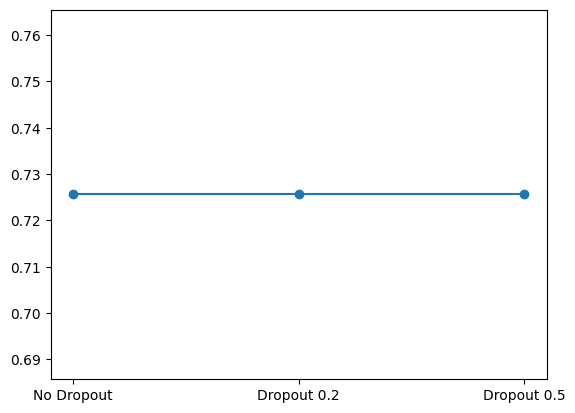

In [ ]:
class DRNet(nn.Module):
  def __init__(self, dr):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    self.dropout = nn.Dropout(dr)
    self.fc1 = nn.Linear(64 * 8 * 8, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    return x

Models = []
for dr in [0, 0.2, 0.5]:
  torch.manual_seed(30)
  net = ChannelNet(ch).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models, ["No Dropout", "Dropout 0.2", "Dropout 0.5"])

**Residual Connection**

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, ch):
    super().__init__()
    self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(ch)
    self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(ch)
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    return F.relu(out + x)


class RNet(nn.Module):
  def __init__(self, depth):
    super().__init__()
    self.conv = nn.Conv2d(3, 32, 3, padding=1)
    self.reslayers = nn.Sequential(*[ResBlock(32) for i in range(depth)])
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv(x)))
    x = self.pool(F.relu(self.reslayers(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


Models = []
for d in [2, 3, 4, 5]:
  torch.manual_seed(30)
  net = RNet(d).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showAcc(Models, [2, 3, 4, 5])

**Different Residual Blocks**

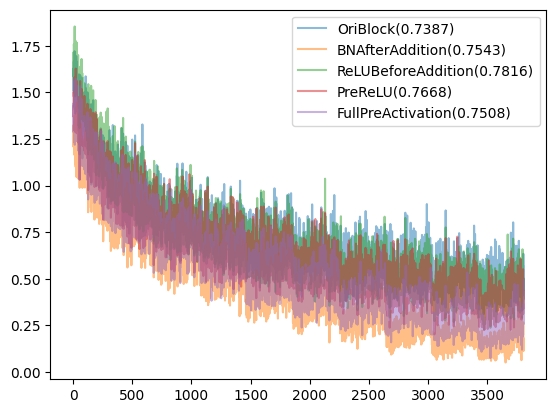

In [ ]:
class OriBlock(ResBlock):
  def __init__(self, ch):
    super().__init__(ch)
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(x))
    return F.relu(out + x)


class BNAfterAddition(ResBlock):
  def __init__(self, ch):
    super().__init__(ch)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.conv2(out)
    return F.relu(self.bn2(out + x))


class ReLUBeforeAddition(ResBlock):
  def __init__(self, ch):
    super().__init__(ch)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    return (out + x)


class PreReLU(ResBlock):
  def __init__(self, ch):
    super().__init__(ch)

  def forward(self, x):
    out = self.bn1(self.conv1(F.relu(x)))
    out = self.bn2(self.conv2(F.relu(out)))
    return (out + x)


class FullPreActivation(ResBlock):
  def __init__(self, ch):
    super().__init__(ch)

  def forward(self, x):
    out = self.conv1(F.relu(self.bn1(x)))
    out = self.conv2(F.relu(self.bn2(out)))
    return (out + x)


class BlockNet(nn.Module):
  def __init__(self, block):
    super().__init__()
    self.conv = nn.Conv2d(3, 32, 3, padding=1)
    self.reslayers = nn.Sequential(*[block(32) for i in range(5)])
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv(x)))
    x = self.pool(F.relu(self.reslayers(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


Models = []
for block in [OriBlock, BNAfterAddition, ReLUBeforeAddition, PreReLU, FullPreActivation]:
  torch.manual_seed(30)
  net = BlockNet(block).to(device)
  optimizer = optim.Adam(net.parameters(), lr=1e-3)
  Models.append((net, nn.CrossEntropyLoss(), optimizer))
showLoss(Models, ["OriBlock", "BNAfterAddition", "ReLUBeforeAddition", "PreReLU", "FullPreActivation"])

**Different Optimizers**

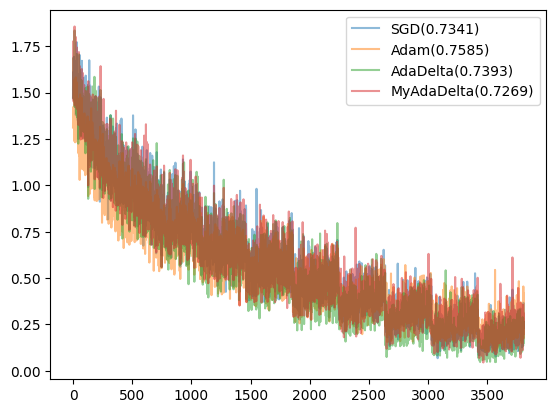

In [ ]:
class MyAdadelta(optim.Optimizer):
  def __init__(self, named_params, lr, rho=0.9, eps=1e-6, weight_decay=0):
    params = [{"params": (p for name, p in named_params if 'bias' not in name and 'embed' not in name), "weight_decay": weight_decay},
              {"params": (p for name, p in named_params if 'bias' in name or 'embed' in name), "weight_decay": 0}]
    super().__init__(params, {"lr":lr, "rho":rho, "eps":eps})
  
  def step(self, closure=None):
    loss = None
    if closure is not None:
      loss = closure()
    
    for group in self.param_groups:
      lr = group["lr"]
      wd = group["weight_decay"]
      rho = group["rho"]
      eps = group["eps"]
      for p in group["params"]:
        if p.grad is None:
          continue
        grad = p.grad.data
        state = self.state[p]
        if len(state) == 0:
          state['step'] = 0
          state['v'] = torch.zeros_like(p.data)
          state['u'] = torch.zeros_like(p.data)
        v = state['v']
        u = state['u']
        state['step'] += 1
        if wd:
          grad.add_(wd * p.data)
        v.mul_(rho).addcmul_(grad, grad,value=1 - rho)
        delta = u.add(eps).sqrt() / v.add(eps).sqrt() * grad
        u.mul_(rho).addcmul_(delta, delta, value=1 - rho)
        p.data.add_(delta, alpha=-lr)


loss_func = nn.CrossEntropyLoss()
torch.manual_seed(30)
Net1 = BlockNet(FullPreActivation).to(device)
torch.manual_seed(30)
Net2 = BlockNet(FullPreActivation).to(device)
torch.manual_seed(30)
Net3 = BlockNet(FullPreActivation).to(device)
torch.manual_seed(30)
Net4 = BlockNet(FullPreActivation).to(device)
sgd = optim.SGD(Net1.parameters(), lr=1e-1, momentum=0.9, nestorov=True)
adam = optim.Adam(Net2.parameters(), lr=1e-3)
ranger = Ranger21(Net3.parameters(), lr=1e-3, num_epochs=10, steps_)
myAdadelta = MyAdadelta(Net4.named_parameters(), lr=1, weight_decay=1e-4)
Models = [(Net1, loss_func, sgd), (Net2, loss_func, adam), (Net4, loss_func, myAdadelta), (Net3, loss_func, range)]
showLoss(Models,["SGD","Adam","MyAdaDelta","Ranger21"])

**Data Augmentation**

In [ ]:
aug_transform = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.RandomCrop(32, padding=4),
    # torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(10, interpolation=Image.BILINEAR),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

aug_trainset = torchvision.datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
aug_trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

def aug_train(model, epoch, criterion, optimizer):
  converge_hist = []
  step = 0
  for i in range(epoch):
    model.train()
    for image, label in aug_trainloader:
      image = image.to(device)
      label = label.to(device)
      optimizer.zero_grad()
      logit = model(image)
      loss = criterion(logit, label)
      loss.backward()
      optimizer.step()
      step += 1
      converge_hist.append(loss.item())
  model.eval()
  acc = evaluate(model)
  return acc, converge_hist

torch.manual_seed(30)
net = BlockNet(FullPreActivation).to(device)
acc = aug_train(net, 10, nn.CrossEntropyLoss(), optim.Adam(net.parameters(), lr=1e-3))[0]
print("Accuracy on test set with data augmentation: {}".format(acc))
torch.manual_seed(30)
net = BlockNet(FullPreActivation).to(device)
acc = train(net, 10, nn.CrossEntropyLoss(), optim.Adam(net.parameters(), lr=1e-3))[0]
print("Accuracy on test set without data augmentation: {}".format(acc))

Files already downloaded and verified
Accuracy on test set with data augmentation: 0.7446
Accuracy on test set without data augmentation: 0.7448


**BN Insight**

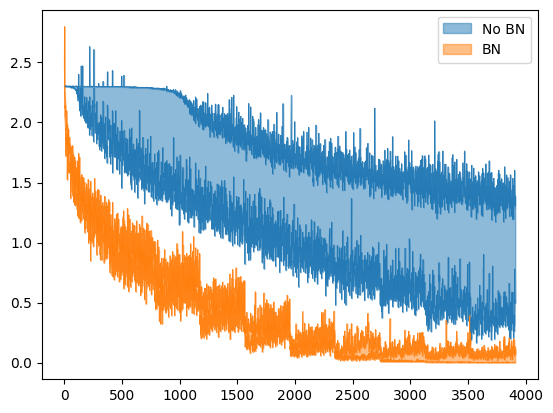

In [ ]:
def init_weights_(m):

  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)

  elif isinstance(m, nn.BatchNorm2d):
    nn.init.ones_(m.weight)
    nn.init.zeros_(m.bias)

  elif isinstance(m, nn.BatchNorm1d):
    nn.init.ones_(m.weight)
    nn.init.zeros_(m.bias)

  elif isinstance(m, nn.Linear):
    nn.init.xavier_normal_(m.weight)
    if m.bias is not None:
      nn.init.zeros_(m.bias)

class VGG(nn.Module):

  def __init__(self, activation, inp_ch=3, num_classes=10, init_weights=True):
    super().__init__()

    self.features = nn.Sequential(
      # stage 1
      nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
      nn.activation(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.activation(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.activation(True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.activation(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
      nn.activation(True),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.activation(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage5
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.activation(True),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.activation(True),
      nn.MaxPool2d(kernel_size=2, stride=2)
      )

    self.classifier = nn.Sequential(
      nn.Linear(512 * 1 * 1, 512),
      nn.activation(),
      nn.Linear(512, 512),
      nn.activation(),
      nn.Linear(512, num_classes)
    )

    if init_weights:
      self._init_weights()

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x.view(-1, 512 * 1 * 1))
    return x

  def _init_weights(self):
    for m in self.modules():
      init_weights_(m)


class BNVGG(nn.Module):
  
  def __init__(self, inp_ch=3, num_classes=10, init_weights=True):
    super().__init__()

    self.features = nn.Sequential(
      # stage 1
      nn.Conv2d(in_channels=inp_ch, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage 2
      nn.BatchNorm2d(64),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage 3
      nn.BatchNorm2d(128),
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.BatchNorm2d(256),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage 4
      nn.BatchNorm2d(256),
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.BatchNorm2d(512),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2),

      # stage5
      nn.BatchNorm2d(512),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.BatchNorm2d(512),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(True),
      nn.MaxPool2d(kernel_size=2, stride=2)
      )

    self.classifier = nn.Sequential(
      nn.Linear(512 * 1 * 1, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, num_classes)
    )

    if init_weights:
      self._init_weights()

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x.view(-1, 512 * 1 * 1))
    return x

  def _init_weights(self):
    for m in self.modules():
      init_weights_(m)

torch.manual_seed(30)
ReLU = VGG(nn.ReLU).to(device)
torch.manual_seed(30)
Mish = BNVGG(nn.Mish).to(device)
Models = [NoBN, BN]
showLandscape(Models,["ReLU", "Mish"])